In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import L2
import cv2

### Dataset Retrieval ###

In [2]:
train_path = 'train/train'
test_path = 'test/test'
categories = []
for file in os.listdir(train_path):
    categories.append(file)
categories

['Blueberry',
 'Pear',
 'Strawberry',
 'Avocado',
 'Pomegranate',
 'Pepper Red',
 'Kiwi',
 'Lemon',
 'Raspberry',
 'Plum',
 'Cherry',
 'Cucumber Ripe',
 'Clementine',
 'Watermelon',
 'Cantaloupe',
 'Apple Braeburn',
 'Onion White',
 'Mango',
 'Potato Red',
 'Passion Fruit',
 'Apple Granny Smith',
 'Apricot',
 'Limes',
 'Corn',
 'Banana',
 'Grape Blue',
 'Cactus fruit',
 'Papaya',
 'Pineapple',
 'Tomato',
 'Orange',
 'Pepper Green',
 'Peach']

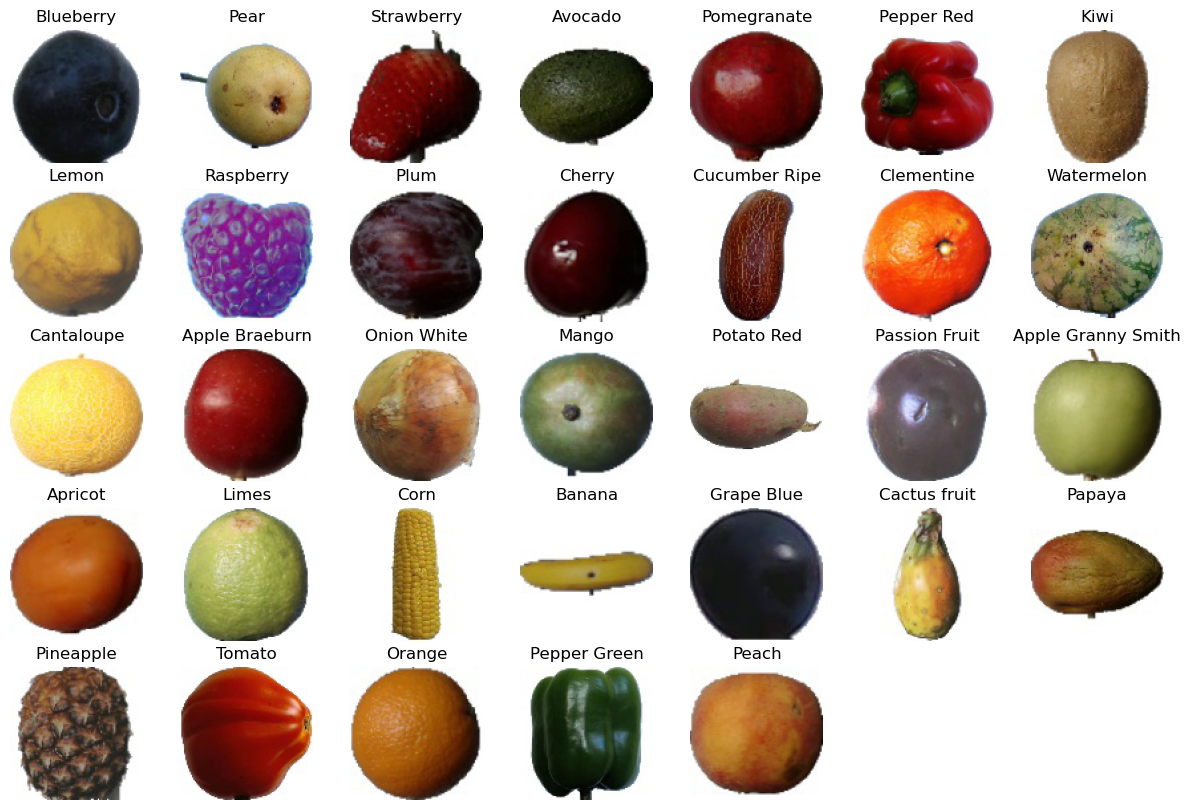

In [3]:
def show_img(path, category):
    folder_path = os.path.join(path, category)
    random_img = random.sample(os.listdir(folder_path),1)
    img = mpimg.imread(os.path.join(folder_path,random_img[0]))
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')

plt.figure(figsize=(15,10))
for i in range(len(categories)):
    plt.subplot(5,7,i+1)
    show_img(train_path,categories[i])

In [4]:

train_data = {'folder_path': [], 'filename' : [], 'label' : []}
for cat in categories:
    folder_path = os.path.join(train_path, cat)
    for file in os.listdir(folder_path):
        train_data['folder_path'].append(folder_path)
        train_data['filename'].append(file)
        train_data['label'].append(cat)

train_df = pd.DataFrame(train_data)
train_df.shape

(16854, 3)

In [5]:
test_data = {'path': [],'filename': []}
for file in os.listdir(test_path):
    test_data['path'].append(test_path)
    test_data['filename'].append(file)

test_df = pd.DataFrame(test_data)
test_df.head()

,path,filename
0,test/test,0071.jpg
1,test/test,4217.jpg
2,test/test,3578.jpg
3,test/test,2666.jpg
4,test/test,5109.jpg


<BarContainer object of 33 artists>

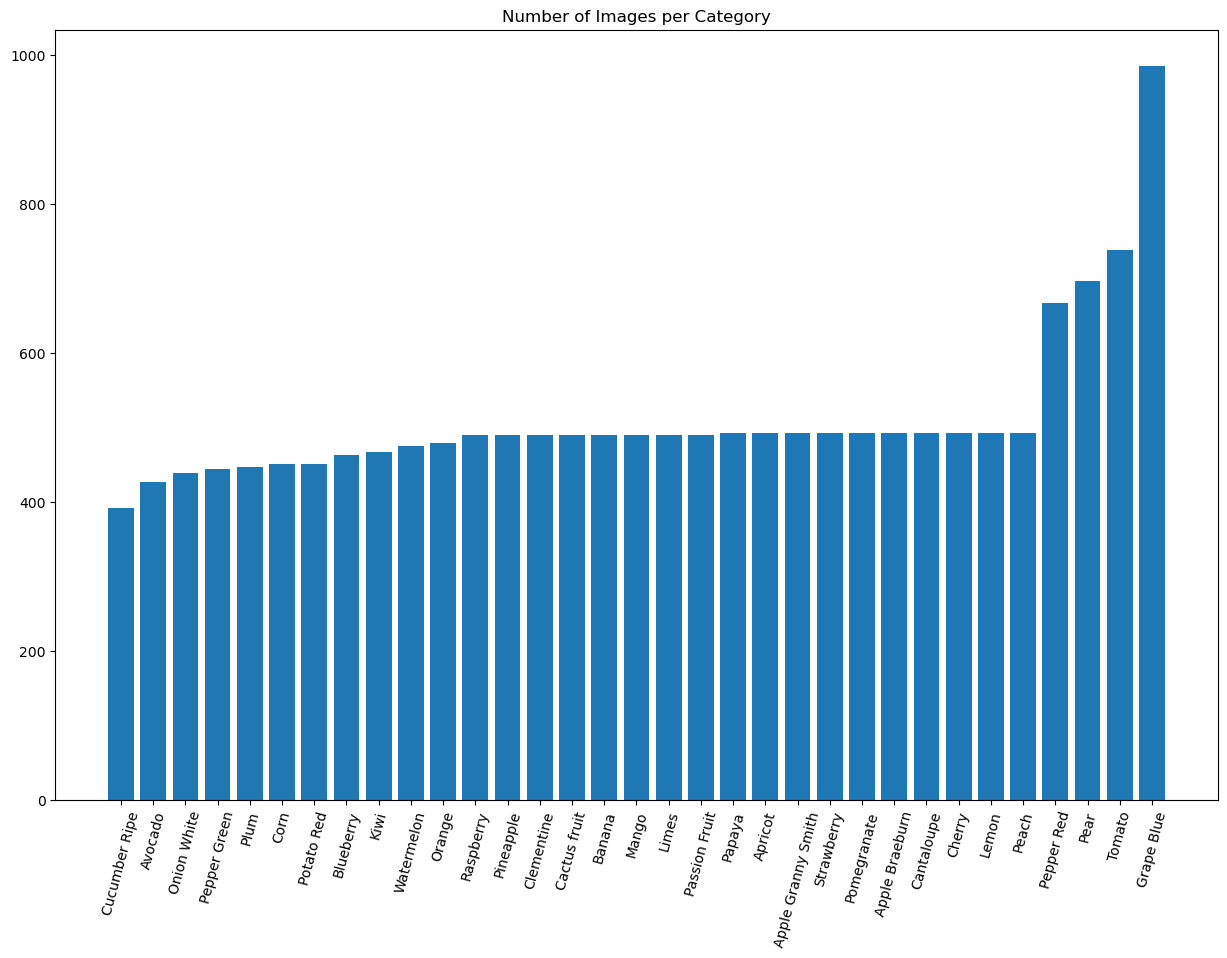

In [6]:
freq_dict = train_df['label'].value_counts(ascending=True).to_dict()
plt.figure(figsize=(15,10))
plt.title('Number of Images per Category')
plt.xticks(rotation=75)
plt.bar(freq_dict.keys(),freq_dict.values())

In [7]:
images = []
labels = []
for i, row in train_df.iterrows():
    img = load_img(os.path.join(row['folder_path'], row['filename']))
    images.append(img_to_array(img))
    labels.append(row['label'])
images = np.array(images)
labels = np.array(labels)
print(f'Images shape: {images.shape}, Labels shape: {labels.shape}')

Images shape: (16854, 100, 100, 3), Labels shape: (16854,)


In [8]:
category_numerical = dict(zip(categories,range(len(categories))))
labels_encoded = list(map(category_numerical.get, labels))
labels_one_hot = to_categorical(labels_encoded, num_classes=len(categories), dtype='uint8')
labels_one_hot.shape

(16854, 33)

In [9]:
train_X, val_X, train_y, val_y = train_test_split(images,labels_one_hot,test_size=0.2,stratify=labels_one_hot, random_state=42)
print("Train set shape", train_X.shape)
print("Validation set shape", val_X.shape)
print("Validation labels shape", val_y.shape)


Train set shape (13483, 100, 100, 3)
Validation set shape (3371, 100, 100, 3)
Validation labels shape (3371, 33)


In [10]:
train_X = (train_X / 255) - 0.5
val_X = (val_X / 255) - 0.5

In [11]:
filters = 3
kernel_size = 3
input_shape = train_X.shape[1:]
pool_size = 2

model = Sequential([
    Conv2D(filters=filters, kernel_size=kernel_size, input_shape=input_shape, activation='relu', kernel_regularizer=L2(l=0.01)),
    MaxPooling2D(pool_size=pool_size, padding='valid'),
    Flatten(),
    Dense(len(categories),activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-14 23:53:52.954546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-14 23:53:52.955346: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 3)         84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 3)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7203)              0         
                                                                 
 dense (Dense)               (None, 33)                237732    
                                                                 
Total params: 237,816
Trainable params: 237,816
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(train_X,train_y,epochs=3)

Epoch 1/3


2023-01-14 23:53:54.139545: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-14 23:53:54.487685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


422/422 [==============================] - 10s 19ms/step - loss: 0.3397 - accuracy: 0.9187
Epoch 2/3
422/422 [==============================] - 8s 18ms/step - loss: 0.0435 - accuracy: 0.9984
Epoch 3/3
422/422 [==============================] - 8s 18ms/step - loss: 0.0323 - accuracy: 0.9991


In [13]:
predictions = model.evaluate(val_X,val_y)

 12/106 [==>...........................] - ETA: 0s - loss: 0.0781 - accuracy: 0.9844

2023-01-14 23:54:20.018250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 1s 10ms/step - loss: 0.0486 - accuracy: 0.9944


In [14]:
test_images = []
for i, row in test_df.iterrows():
    print(row['filename'],i)
    img = load_img(os.path.join(row['path'], row['filename']))
    test_images.append(img_to_array(img))
    if i == 4:
        break
test_images = (np.array(test_images) /255) - 0.5
test_images.shape

0071.jpg 0
4217.jpg 1
3578.jpg 2
2666.jpg 3
5109.jpg 4


(5, 100, 100, 3)

In [15]:
predictions = model.predict(test_images[:5])
np.argmax(predictions,axis=1)

1/1 [==============================] - 0s 130ms/step


2023-01-14 23:54:21.227383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([ 4, 19,  7,  1,  1])

In [16]:
for i in np.argmax(predictions,axis=1):
    print(categories[i])

Pomegranate
Passion Fruit
Lemon
Pear
Pear


## Resizing ##

In [17]:
sample = ''
image = cv2.imread(sample)
h,w,c = image.shape
print("Original Height and Width:", h,"x", w, " Channels:", c)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

[ WARN:0@43.797] global /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_562_cazh1h/croots/recipe/opencv-suite_1664548333142/work/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_(''): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

New Height and Width: 100 x 100  Channels: 3


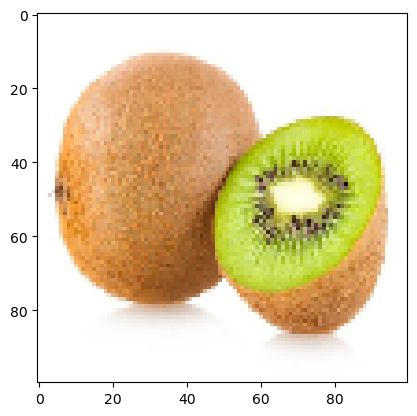

In [ ]:
dsize = (100,100)
resize_down = cv2.resize(image,dsize)
h,w,c = resize_down.shape
print("New Height and Width:", h,"x", w, " Channels:", c)
plt.imshow(resize_down)

In [ ]:
resize_arr = (np.array([img_to_array(resize_down)]) / 255) - 0.5
resize_arr.shape


(1, 100, 100, 3)